# Latent Net implementation

>> Notes to the new implementation - debugging


>> - the implementation of the Fourier features is wrong. get back to that later
>> - make sure that the train function loops over the parameters that are part  of the train set (i.e. the alphas that define the training sims)
>> - the append operation
>> - plot the latent state
>> - remove the train_snaphots and test_snapshots variables
>> - for each parameter, I train always on the same positions. to be changed?

>> using more batches does not work

>> - using 1 batch of 5000 points produces interesting results. (backward ext)
>> - using 1 batch of 7e3 points learns nice on small dataset (1000 epochs, backward ext)


>> - LBFGS
>> - enlarge the networks
>> - try with 90 percent of train dataset 

>> if the backward is external, the predictions are interesting. maybe I should not accumulate the gradients of the positions, check what happens to the actual prediction (despite a different stn, the prediction is always the same in shape, and I dont see why this happens)

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

#torch.set_default_dtype(torch.float32)

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import some utils from gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fra-Sala/gnn_time.git
    sys.path.append('gnn_time')
else:
    sys.path.append('./..')
    
from latent_net import dynamics_network, initialization, loader, preprocessing_scale, train, plotting, testing

In [5]:
variable = 'U'
problem_name = 'lid_cavity'
print("\nProblem: ", problem_name)
print("Variable: ", variable)



Problem:  lid_cavity
Variable:  U


## Set training parameters

In [6]:
train_rate =  50         # percentage of data used for training
dim_latent = 10
epochs = 100
step_integration = 1e-1   # time step forward euler
pos_per_batch = 15681
num_batches = 1
dim_solution = 2
final_time_sim = 2.0      # do not change even if you consider less snapshots (shorter simulations)
argv = [problem_name, variable, train_rate, dim_latent, step_integration, epochs, pos_per_batch, num_batches, final_time_sim, int(dim_solution)]
HyperParams = dynamics_network.HyperParams(argv)

# Initialization

In [7]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)

Device used:  cpu


# Load dataset

In [8]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gnn_time/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'

# Import the data from the mat file  and get rid of the initial condition for each simulation
dataset = loader.LoadDataset(dataset_dir, variable)

def delete_initial_condition(dataset, dim):
    if dim == 1:
        dataset.U = np.delete(dataset.U, np.s_[::10], 1)
    elif dim == 2:
        indices_to_remove = list(range(0, dataset.U.shape[1], 20)) + list(range(1, dataset.U.shape[1], 20))
        dataset.U = np.delete(dataset.U, indices_to_remove, 1)
    else:
        print("Invalid dimension. Please enter 1 or 2.")
    return dataset.U

dataset.U = delete_initial_condition(dataset, HyperParams.dim)

if 'google.colab' in str(get_ipython()):
    params = np.load('/content/gnn_time/lid_driven_cavity_fenics/alpha1.npy')
else:
    params = np.load('../lid_driven_cavity_fenics/alpha1.npy')

# Array of time over which the simulations were created
time = np.linspace(0.0, 1.8, 10)

In [9]:
# DEBUG: shrink the dataset
num_sim2keep = 2 # not greater than 20, in total (train and test, before application of train_rate)
num_snap2keep = 1 # not greater than 9


def shrink_dataset(U, params, time, num_sim, num_snap_per_sim, dim):
    new_time = time[:num_snap_per_sim+1]
    new_params = params[:num_sim]
    new_U = []
    for i in range(num_sim):
        start = i * (len(time) - 1)*HyperParams.dim
        end = start + num_snap_per_sim*HyperParams.dim
        new_U.append(U[:, start:end])
 
    new_U = np.concatenate(new_U, axis=1)
    return new_U, new_time, new_params


dataset.U, time, params = shrink_dataset(dataset.U, params, time, num_sim2keep, num_snap2keep, HyperParams.dim)

time_tensor = torch.from_numpy(time)

#print("Number of simulations (series of snaps):", len(params))
#print("Number of instants of time (initial time excluded):", len(time)-1)


In [10]:
train_loader, test_loader, scaler_all,\
scaler_test, VAR_all, VAR_test, train_snapshots,\
test_snapshots, position_dataset, params_train, params_test = preprocessing_scale.process_and_scale_dataset(dataset, HyperParams, params)

Number of nodes processed:  15681
Number of simulations processed:  8


In [11]:
# data_train_iterator = iter(train_loader)
# data_train = next(data_train_iterator).to(device)
# data_train.shape


## This should be followed to scale back the data


# alpha0, alphaw = scaler_all[0], scaler_all[1]
# scaled_back_test = preprocessing_scale.inverse_normalize_input(data_test, alpha0, alphaw, np.arange(18,36,1))
# print("Scaled back trian or test dataset")
# scaled_back_test[:, 0:20, 0]



# Define the architecture

In [12]:
# DYN NN
dyn_input_size = 1 + HyperParams.dim_latent
dyn_hidden_size = 20
space_dim = 2

# REC NN
rec_input_size = space_dim + HyperParams.dim_latent#*HyperParams.batch_pos_size + HyperParams.dim_latent
rec_hidden_size = 25
rec_output_size = HyperParams.dim #HyperParams.batch_pos_size*HyperParams.dim

dyn_model = dynamics_network.DynNet(dyn_input_size, dyn_hidden_size, HyperParams.dim_latent)
rec_model = dynamics_network.RecNet(rec_input_size, rec_hidden_size, rec_output_size)
dyn_model = dyn_model.to(device)
rec_model = rec_model.to(device)

torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam([
    {'params': dyn_model.parameters()},
    {'params': rec_model.parameters()}
], lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)


# torch.set_default_dtype(torch.float32)
# params = list(dyn_model.parameters()) + list(rec_model.parameters())
# optimizer = torch.optim.LBFGS(params, lr=HyperParams.learning_rate)

# Train the network

No saved network found


100%|██████████| 100/100 [4:47:32<00:00, 172.52s/it, Loss(training)=271, Loss(test)=452]      


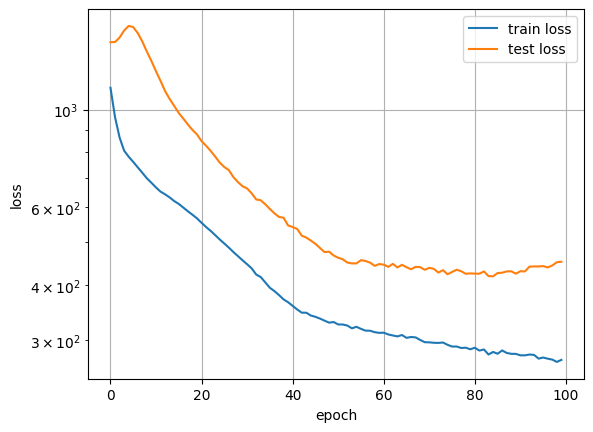

In [13]:
try:
    dyn_model.load_state_dict(torch.load(HyperParams.net_dir + HyperParams.net_name + '_dyn.pt'))
    rec_model.load_state_dict(torch.load(HyperParams.net_dir + HyperParams.net_name + '_rec.pt'))
    print('Loading saved network')
except:
    print('No saved network found')
    train_history, test_history = train.train_dyn_rec_nets(dyn_model, rec_model, optimizer, scheduler,\
                          device, params_train, params_test, time_tensor, train_loader, test_loader, position_dataset, HyperParams)
    plt.figure()
    plt.semilogy(train_history['loss'], label='train loss')
    plt.semilogy(test_history['loss'], label='test loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(HyperParams.net_dir+'loss_train_test.png', bbox_inches='tight', dpi=500)

# Test the model over the test set

In [14]:
from latent_net import plotting, testing
PARAMS = np.repeat(params, len(time)-1, axis=0)
TIMES = np.tile(time[1:], params.shape[0])
# concatenate TIMES and params_test as two columns
#np.random.shuffle(test_snapshots)
snapshots = test_snapshots[:10]


# the rescaling is correct, and the predictions are qualitatively correct
#rescaled_results = preprocessing_scale.inverse_normalize_input(results, scaler_all, snapshots)




# Plot the results

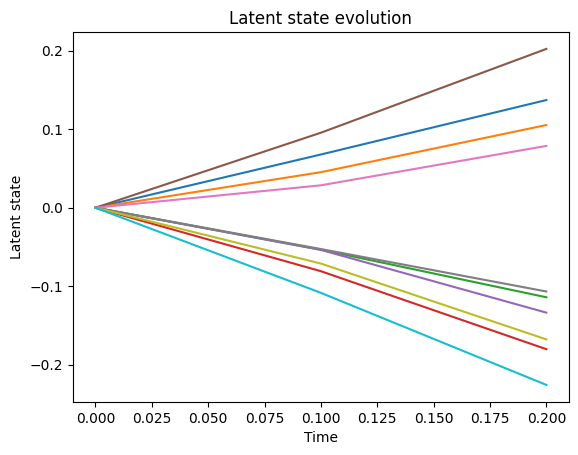

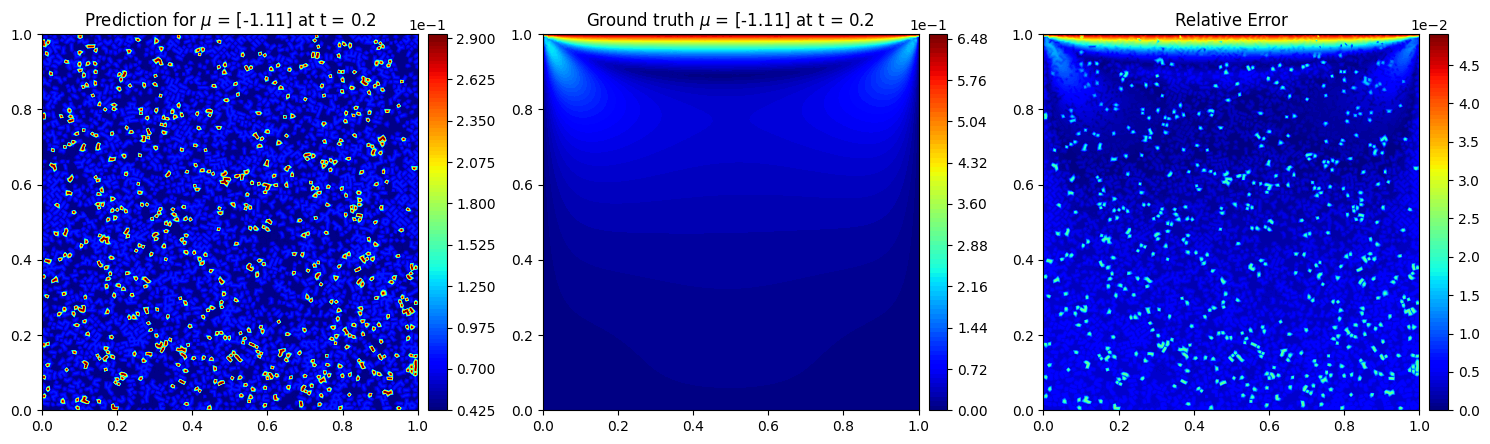

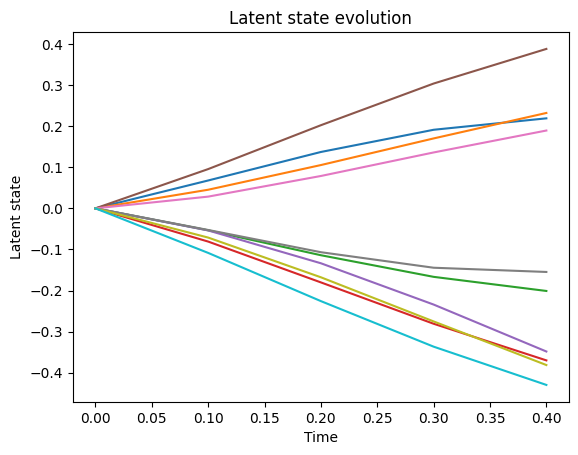

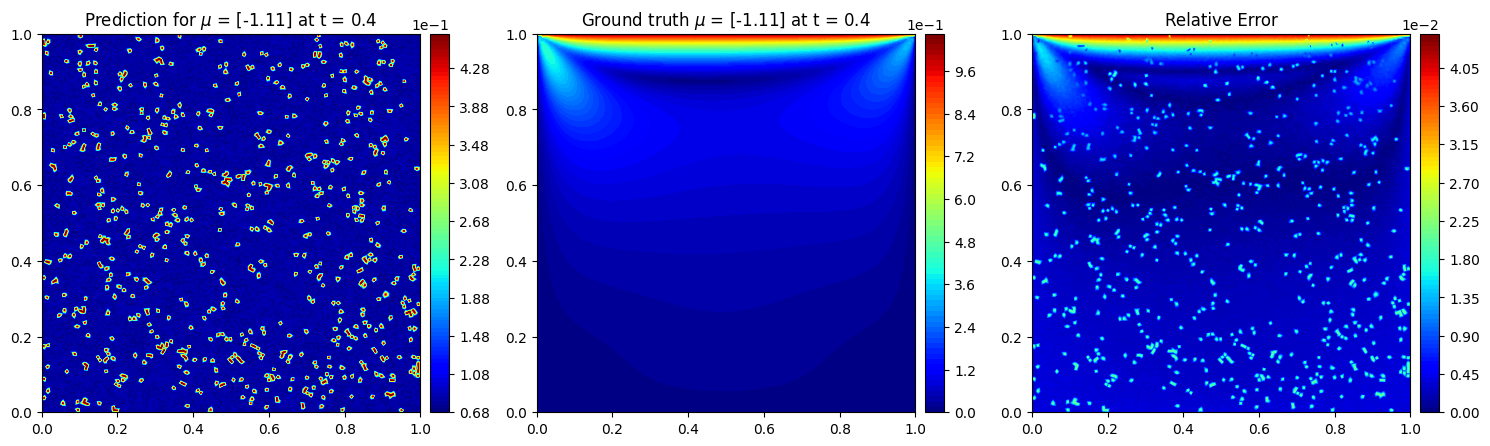

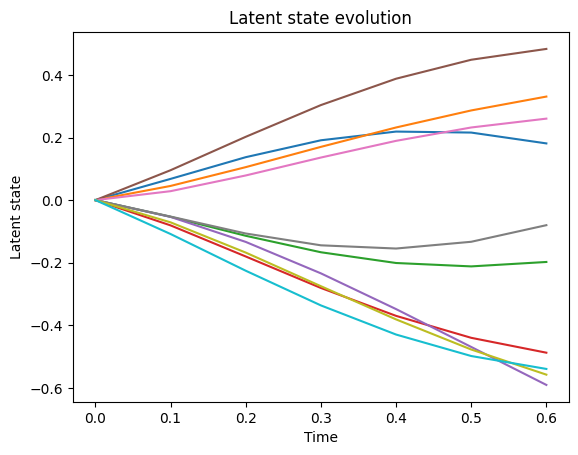

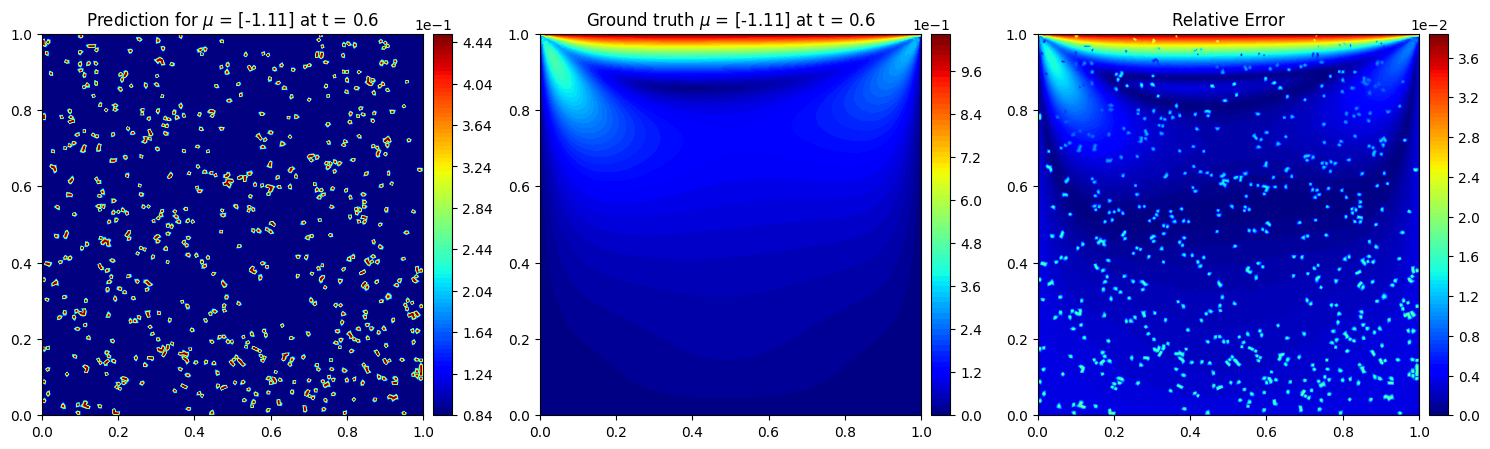

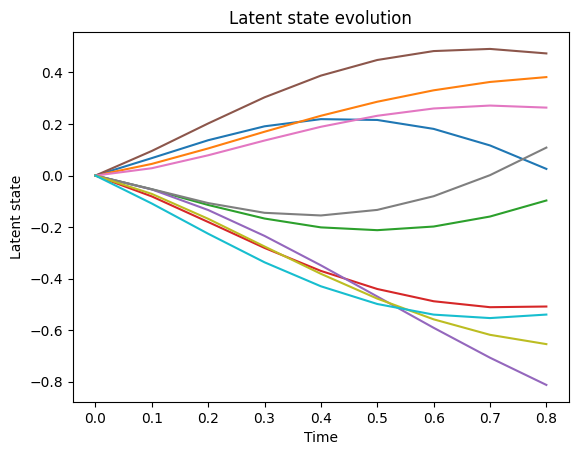

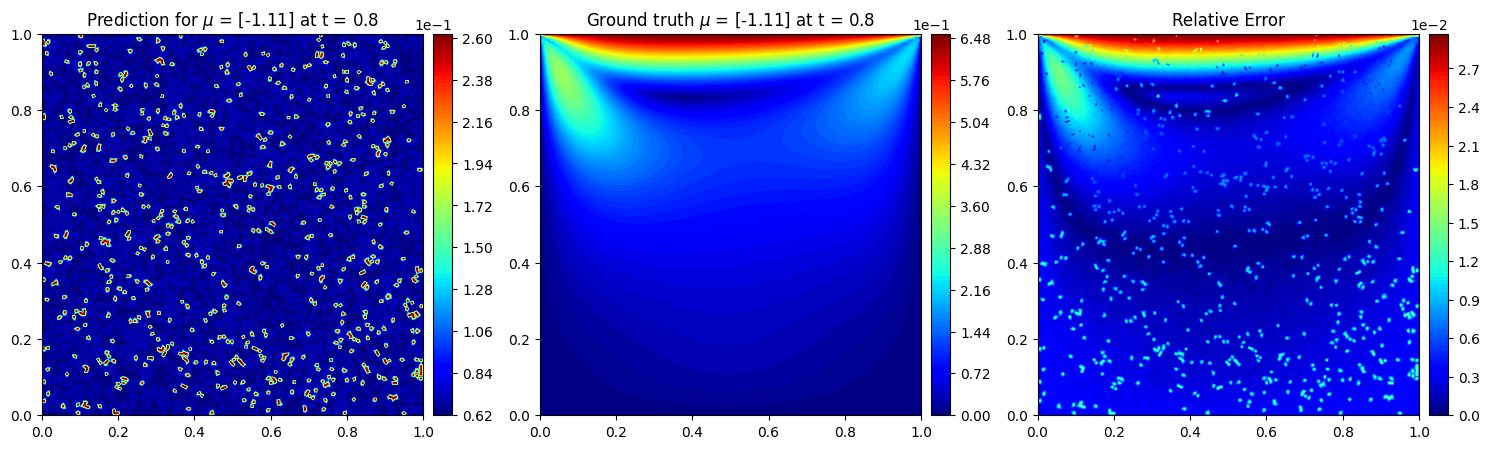

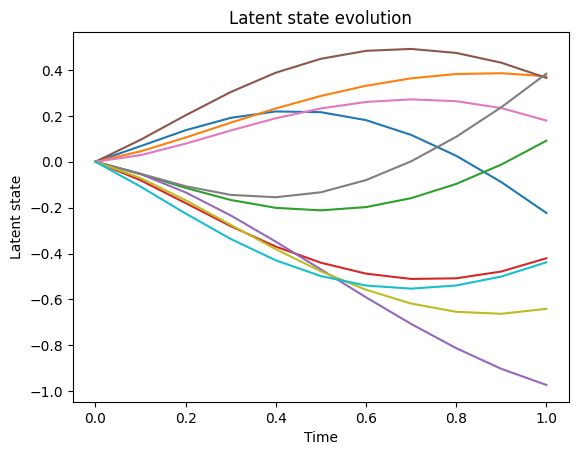

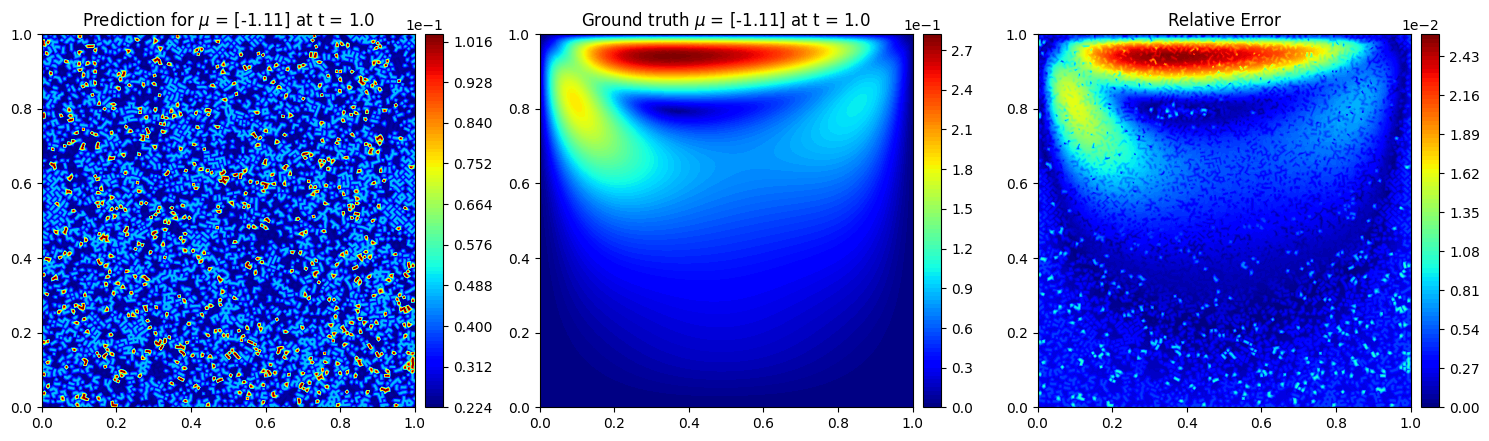

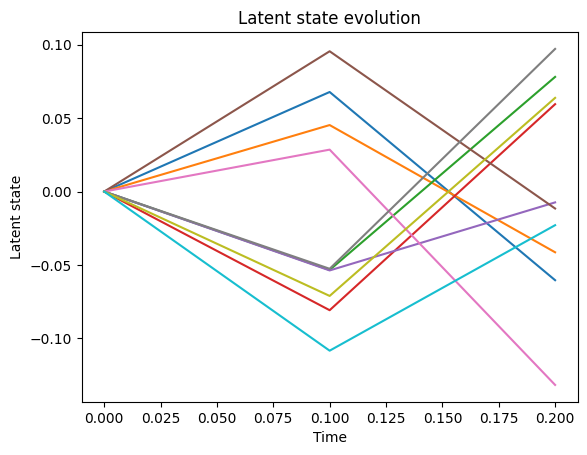

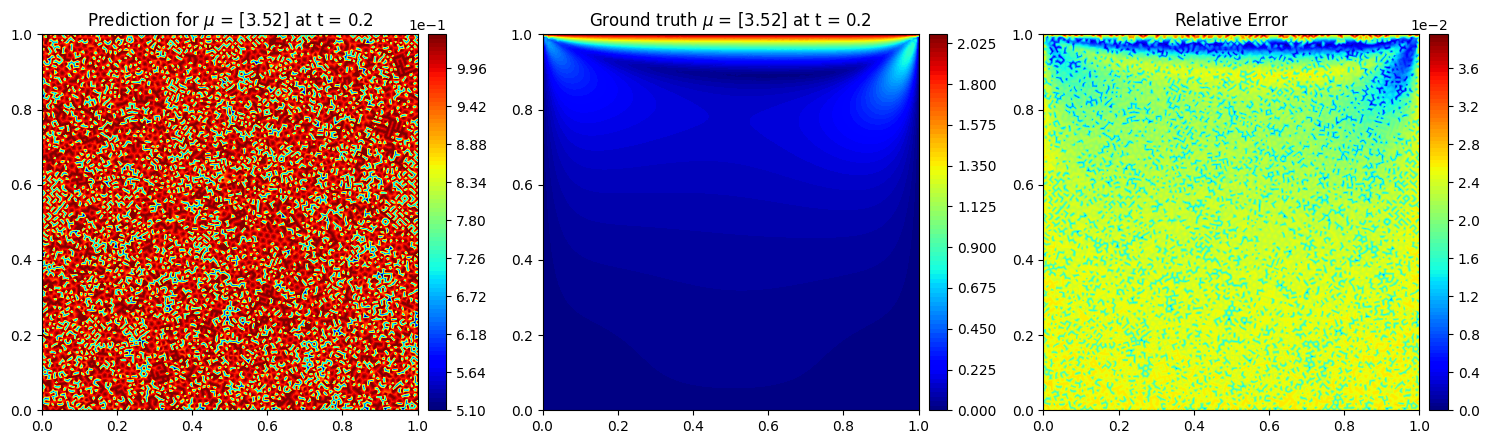

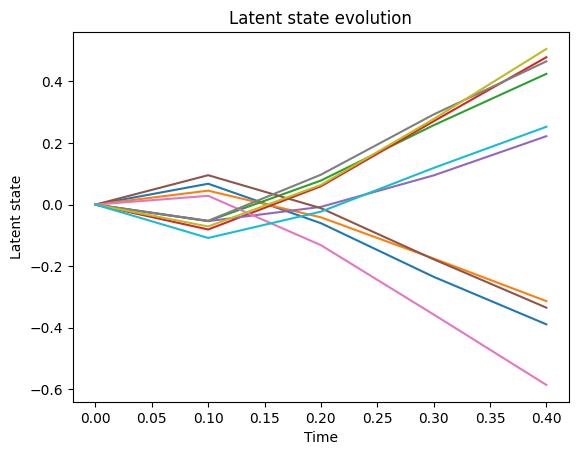

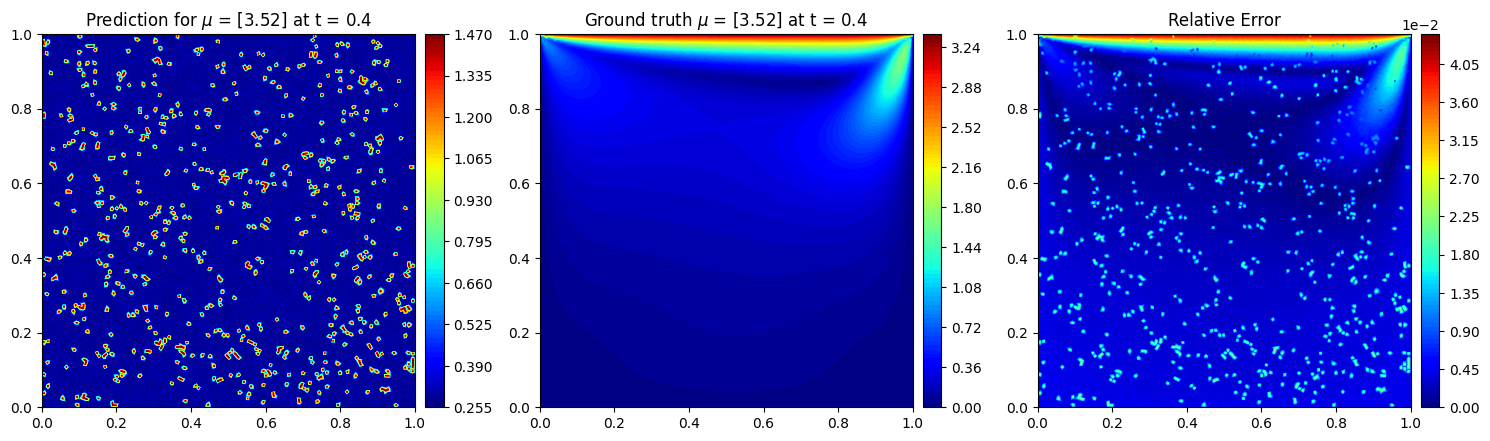

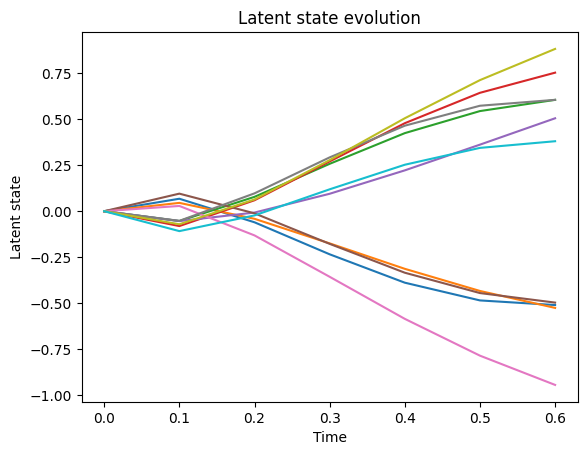

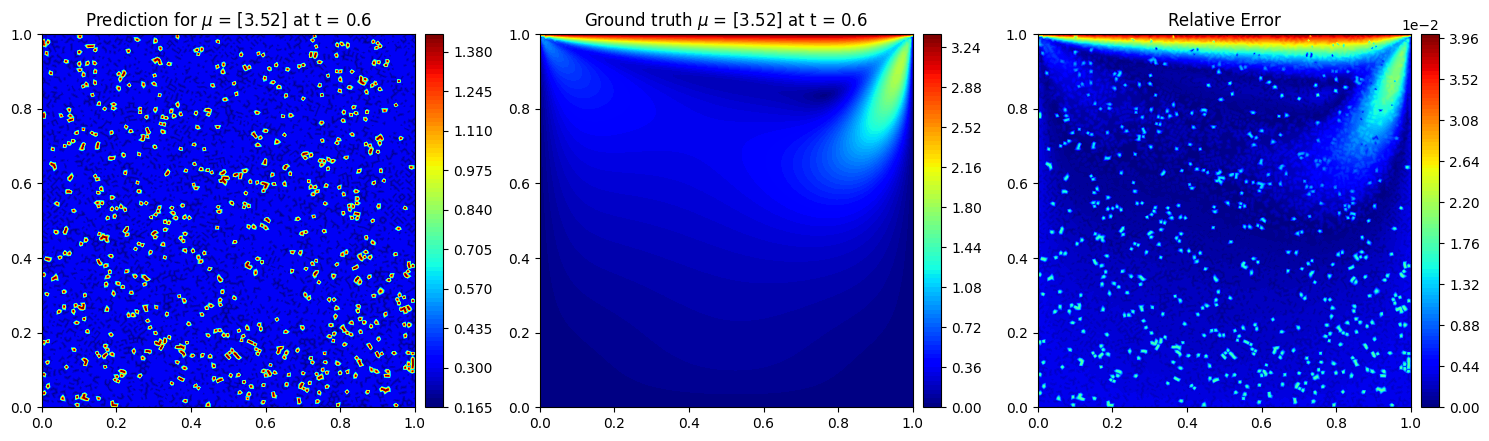

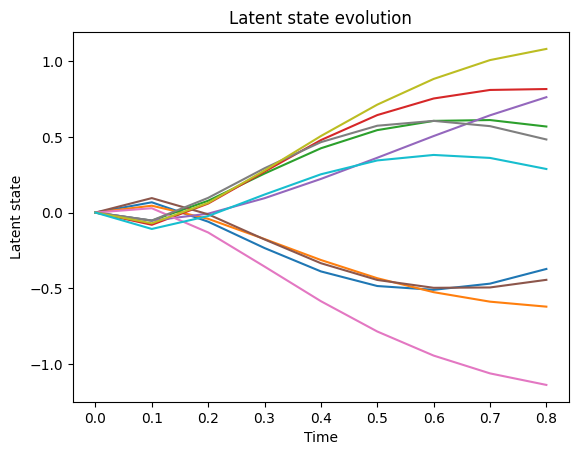

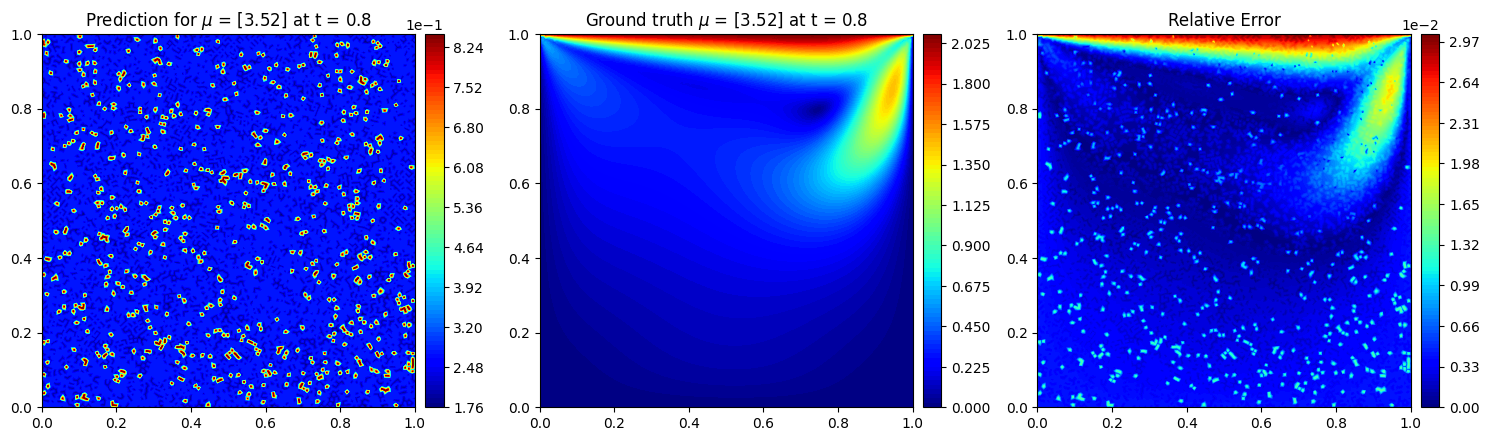

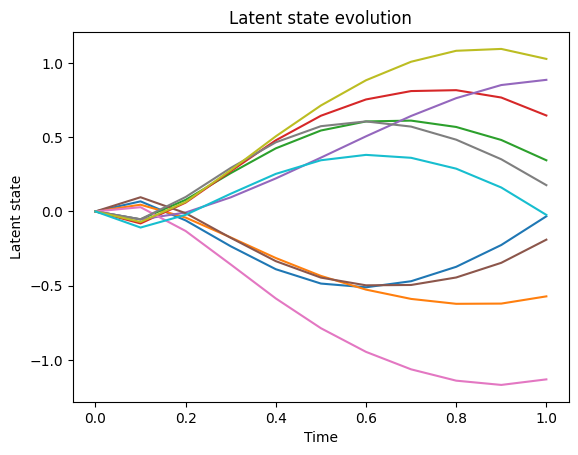

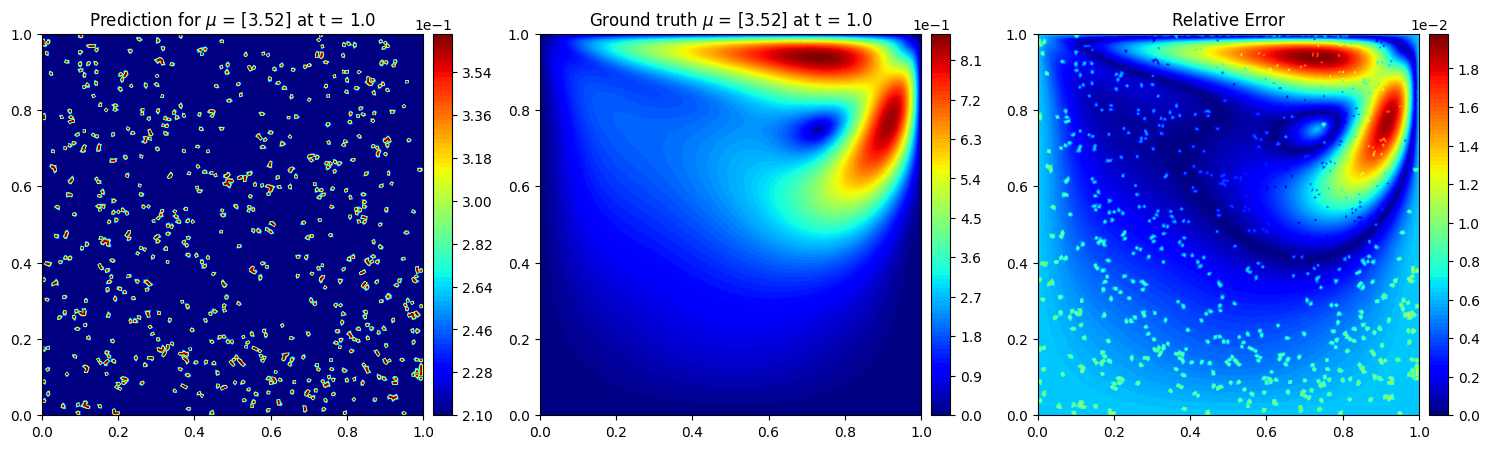

In [15]:
num_pos_requests = len(position_dataset)//HyperParams.batch_pos_size
for i,SNAP in enumerate(snapshots):
    
    Z_net, stn_evolution, time_evolution = testing.test(dyn_model, rec_model, device, PARAMS[SNAP], TIMES[SNAP], position_dataset, num_pos_requests, HyperParams)

    plotting.plot_latent(stn_evolution, time_evolution, SNAP, HyperParams)
        
    plotting.plot_fields(SNAP, Z_net, scaler_all, HyperParams, dataset, PARAMS, TIMES)


In [16]:
# num_iterations = len(position_dataset)//HyperParams.batch_pos_size

# for i,SNAP in enumerate(snapshots):
#     Z_net = torch.zeros((len(position_dataset), HyperParams.dim))
#     for j in range(num_iterations):
#         pos_test = position_dataset[j*HyperParams.batch_pos_size:(j+1)*HyperParams.batch_pos_size]
#         result, stn_evolution, time_evolution = testing.test(dyn_model, rec_model, device, PARAMS[SNAP], TIMES[SNAP], pos_test, HyperParams)
#         if HyperParams.dim == 1:
#             Z_net[j*HyperParams.batch_pos_size:(j+1)*HyperParams.batch_pos_size, 0] = result
#         if HyperParams.dim == 2:
#             Z_net[j*HyperParams.batch_pos_size:(j+1)*HyperParams.batch_pos_size, 0] = result[:len(result) // 2]
#             Z_net[j*HyperParams.batch_pos_size:(j+1)*HyperParams.batch_pos_size, 1] = result[len(result) // 2:]
     

#     plotting.plot_latent(stn_evolution, time_evolution)
    
#     plotting.plot_fields(SNAP, Z_net, scaler_all, HyperParams, dataset, PARAMS, TIMES)
#     i+1

In [17]:
position_dataset[0:20, 0]

tensor([-1.0000, -1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000, -1.0000,
         0.0000, -1.0000, -0.5000, -0.5000, -1.0000,  1.0000,  0.5000,  1.0000,
         0.5000,  0.4167, -0.4167, -0.2500], dtype=torch.float64)

In [18]:
dataset.xx[0:20, 0]

tensor([0.0000, 0.0000, 1.0000, 1.0000, 0.5000, 1.0000, 0.5000, 0.0000, 0.5000,
        0.0000, 0.2500, 0.2500, 0.0000, 1.0000, 0.7500, 1.0000, 0.7500, 0.7083,
        0.2917, 0.3750], dtype=torch.float64)